In [117]:
!pip install PyDrive
!pip install gensim
!pip install pyldavis
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 435 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [118]:
from google.colab import drive
drive.mount('/drive')  # Add My Drive/<>

import os
os.chdir('/drive/My Drive/ProjectNLP')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [119]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy
import warnings
warnings.filterwarnings("ignore")

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [121]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [122]:
df1 = getDF('AMAZON_FASHION.json.gz')
df1.shape

(883636, 12)

In [123]:
df2 = getDF('meta_AMAZON_FASHION.json.gz')
df2.shape

(186637, 16)

In [124]:
df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,true,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,true,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,true,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,true,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,true,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


In [125]:
df1.groupby(['asin']).count()['overall'].sort_values(ascending=False)

asin
B000V0IBDM    4384
B000KPIHQ4    4375
B00I0VHS10    3889
B00RLSCLJM    3638
B000PHANNM    2572
              ... 
B00UW87NIM       1
B00UW86OAU       1
B00UW6XCT8       1
B00UW6RIE8       1
B00Y9Z75FA       1
Name: overall, Length: 186189, dtype: int64

In [126]:
df2.head()

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,"Slime Time Fall Fest [With CDROM and Collector Cards and Neutron Balls, Incredi-Ball and Glow Stick Necklace, Paper Fram",Group Publishing (CO),"[Product Dimensions:\n \n8.7 x 3.6 x 11.4 inches, Shipping Weight:\n \n2.4 pounds]","13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL._US40_.jpg],[https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL.jpg],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men's accessories alloy fittings magnet buckle bracelet jewelry,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,"[https://images-na.ssl-images-amazon.com/images/I/41BCH7-4vHL._US40_.jpg, https://images-na.ssl-images-amazon.com/images/I/41FpbB--SoL._US40_.jpg, https://images-na.ssl-images-amazon.com/images/I/...","[https://images-na.ssl-images-amazon.com/images/I/41BCH7-4vHL.jpg, https://images-na.ssl-images-amazon.com/images/I/41FpbB--SoL.jpg, https://images-na.ssl-images-amazon.com/images/I/51twQYJo0NL.jpg]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,Christopher Manos,"[Package Dimensions:\n \n8.5 x 5.5 x 0.4 inches, Shipping Weight:\n \n6.1 ounces]","19,308,073inClothing,ShoesJewelry(",5 star,1940280001,"[https://images-na.ssl-images-amazon.com/images/I/4196%2BTu5T%2BL._SR38,50_.jpg, https://images-na.ssl-images-amazon.com/images/I/31N2zBaedSL._SR38,50_.jpg]","[https://images-na.ssl-images-amazon.com/images/I/4196%2BTu5T%2BL.jpg, https://images-na.ssl-images-amazon.com/images/I/31N2zBaedSL.jpg]","[For the professional or amateur magician. Routines include: The Thought Transmitter (An accidental USAF experiment that became a hit at the Denver Playboy Club and continues through today!), Thr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,"[Package Dimensions:\n \n8.3 x 5.5 x 0.3 inches, Shipping Weight:\n \n5.6 ounces]","19,734,184inClothing,ShoesJewelry(",5 star,1940735033,"[https://images-na.ssl-images-amazon.com/images/I/41VHFlSGjoL._SR38,50_.jpg]",[https://images-na.ssl-images-amazon.com/images/I/41VHFlSGjoL.jpg],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic Book Special Edition - Rare! - Blue Juice Comics,NaN,"[Package Dimensions:\n \n10.5 x 6.5 x 0.2 inches, Shipping Weight:\n \n6.4 ounces (View shipping rates and policies)]","10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,"[https://images-na.ssl-images-amazon.com/images/I/418HGjTDbRL._SR38,50_.jpg]",[https://images-na.ssl-images-amazon.com/images/I/418HGjTDbRL.jpg],NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
df = df1
df.dropna(subset=['reviewText'],inplace=True)

In [128]:
df.isna().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          90
reviewText             0
summary              503
unixReviewTime         0
vote              802715
style             578347
image             854085
dtype: int64

In [129]:
thresh_50Percent = len(df)/2
df.dropna(thresh=thresh_50Percent, axis=1, inplace=True)

In [130]:
df.shape

(882403, 9)

In [131]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5.0,true,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200
1,2.0,true,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400
2,4.0,true,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800
3,2.0,true,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400
4,3.0,true,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200


In [132]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

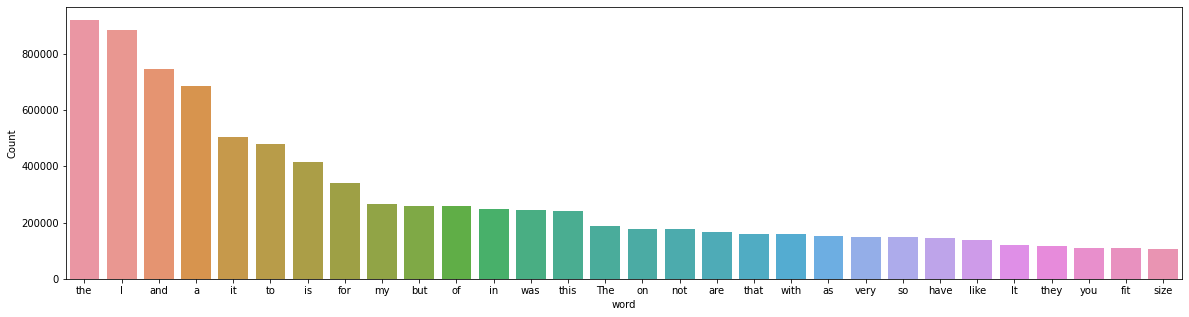

In [133]:
freq_words(df['reviewText'])


In [134]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [135]:
# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [136]:
#remove stop words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
add_stop_words = ['good','cute','great', 'perfect','love','like','would','nice','beautiful','made','ordered','little'\
                  'excellent','loved','thank','received','fast','exactly','expected','really','got','work',\
                  'product','perfectly','honest','also','review','super','awesome','well','came','look','bought'\
                  'recommend','get','arrived','one','buy','happy','year','month','has','was','much','absolutely','pretty']
stop_words = stop_words.union(add_stop_words)

def stopText(text_array):
    h2 = " "
    for h in text_array:
        if h.lower() not in stop_words:
          h2 = h2 + ' ' + h
    return h2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [137]:
import string
# Remove punctuations
def removePuncStr(s):
    for c in string.punctuation:
        s = s.replace(c," ")
    return s

def removePunc(text_array):
    return [removePuncStr(h) for h in text_array]

# Remove numbers
def removeNumbersStr(s):
  for c in range(10):
    n = str(c)
    s = s.replace(n,"")
  return s

def removeNumbers(text_array):
    return [removeNumbersStr(h) for h in text_array]

In [138]:
# Lemmatizing
nltk.download('punkt')
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [139]:
def lemmText(text):
    WNlemmatizer = WordNetLemmatizer()
    lemmatized_text = ''

    words = word_tokenize(text) 
    for w in words:
        lemmatized_text = lemmatized_text + ' ' + WNlemmatizer.lemmatize(w)
    return lemmatized_text


In [140]:
import gensim
from gensim import corpora

## Check Topics that are most common for lower rating reviews with Rating 1

In [141]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5.0,true,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200
1,2.0,true,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400
2,4.0,true,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800
3,2.0,true,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400
4,3.0,true,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200


In [142]:
df.dtypes

overall           float64
verified           object
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
dtype: object

In [143]:
df[df['overall']<2].shape

(106984, 9)

In [144]:
lowerdf=df[df['overall']<2].reset_index()

In [145]:
lowerdf.head()

,index,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,12,1.0,true,"01 4, 2013",A1G3S57JGZNPCL,B00007GDFV,kimberly a schotthoefer,"cheap and cheesy, but i guess i could have expected that for the price, won't purchase another without seeing first",inexpensive case,1357257600
1,13,1.0,true,"07 30, 2012",AGBL3TTP6GV4X,B00007GDFV,gallina,"I ordered a ladies cigarette case for my wife, and a pack of Marlboro 100's would not fit in the case!!!! I was ripped off!!! A cigarette case should be able to hold any cigarette pack!!!! I wi...",i was ripped off!!!!,1343606400
2,21,1.0,true,"07 27, 2017",A19OTBIPAMJUU1,B00007GDFV,Constance J Tomazic,Don't like it. It will not hold my cigarettes. Not long enough.,One Star,1501113600
3,28,1.0,true,"05 28, 2017",A3BAY1QXF3EWNZ,B00007GDFV,yolanda,Does not hold 120s to small for a lighter,One Star,1495929600
4,29,1.0,true,"05 5, 2017",A2Z3HHIK3TTV0G,B00007GDFV,Amazon Customer,"It fits my cigarettes, however very cheep material and smaller than the usual size of these. I would never purchase another one. It seems like a dollar store item",Smaller in size than usual cigarette pouch,1493942400


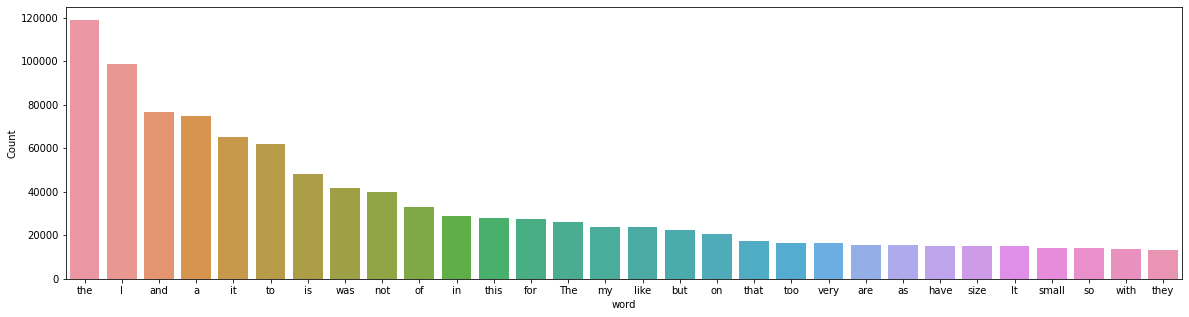

In [146]:
freq_words(lowerdf['reviewText'])


In [147]:
lowerdf['reviewText'] = lowerdf['reviewText'].apply(lambda x: removePuncStr(x))
lowerdf['reviewText'] = lowerdf['reviewText'].apply(lambda x: remove_stopwords(x.split()))
lowerdf['reviewText'] = lowerdf['reviewText'].apply(lambda x: removeNumbersStr(x))
lowerdf['reviewText'] = lowerdf['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
lowerdf['reviewText'] = lowerdf['reviewText'].apply(lambda x: str(x).lower())

In [148]:
lowerdf['reviewText'][:5]

0                                                                                                        cheap cheesy guess could price purchase another without seeing first
1    ladies cigarette case wife pack marlboro fit case ripped cigarette case able hold cigarette pack business silverhooks even worth postage send back dissatisfied big time
2                                                                                                                                         don hold cigarettes not long enough
3                                                                                                                                                     does hold small lighter
4                                                                    fits cigarettes however cheep material smaller usual size never purchase another seems dollar store item
Name: reviewText, dtype: object

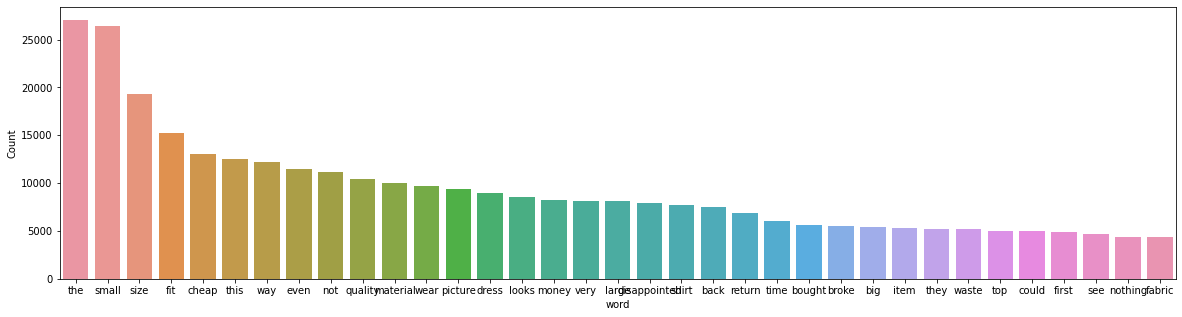

In [149]:

freq_words(lowerdf['reviewText'], 35)

In [150]:
lowerdf['reviewText'] = lowerdf['reviewText'].apply(lambda x: lemmText(x))

In [151]:
lowerdf['reviewText'] = lowerdf['reviewText'].apply(lambda x: remove_stopwords(x.split()))
lowerdf['reviewText'] = lowerdf['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [152]:
lower_tokenized_reviews = lowerdf['reviewText'].apply(lambda x: x.split())
print(lower_tokenized_reviews[1])

['lady', 'cigarette', 'case', 'wife', 'pack', 'marlboro', 'fit', 'case', 'ripped', 'cigarette', 'case', 'able', 'hold', 'cigarette', 'pack', 'business', 'silverhooks', 'even', 'worth', 'postage', 'send', 'back', 'dissatisfied', 'big', 'time']


In [153]:
lower_doc_clean = [doc.split() for doc in lowerdf['reviewText']]
lower_dictionary = corpora.Dictionary(lower_doc_clean)

In [154]:
lower_doc_term_matrix = [lower_dictionary.doc2bow(doc) for doc in lower_doc_clean]

In [155]:
print(len(lower_doc_term_matrix))
print(type(lower_doc_term_matrix))
print(len(lower_doc_term_matrix[0]))
print(len(lower_doc_term_matrix[1]))

106984
<class 'list'>
10
20


In [156]:
%%time 
#RUN THE MODEL
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
lda_model_lower = LDA(corpus=lower_doc_term_matrix,
                id2word=lower_dictionary,
                num_topics=4, 
                random_state=100,
                chunksize=1000,
                passes=50)

CPU times: user 15min 30s, sys: 41.5 s, total: 16min 12s
Wall time: 15min 33s


In [157]:
lda_model_lower.print_topics()

[(0,
  '0.021*"poor" + 0.021*"quality" + 0.018*"time" + 0.018*"first" + 0.017*"broke" + 0.016*"day" + 0.014*"bag" + 0.011*"week" + 0.010*"put" + 0.010*"wear"'),
 (1,
  '0.040*"cheap" + 0.039*"material" + 0.036*"picture" + 0.028*"dress" + 0.021*"quality" + 0.020*"shirt" + 0.018*"color" + 0.018*"fabric" + 0.016*"nothing" + 0.015*"thin"'),
 (2,
  '0.084*"small" + 0.071*"size" + 0.057*"fit" + 0.037*"way" + 0.024*"large" + 0.021*"wear" + 0.015*"even" + 0.015*"shirt" + 0.015*"big" + 0.014*"top"'),
 (3,
  '0.024*"return" + 0.017*"back" + 0.015*"item" + 0.014*"money" + 0.011*"star" + 0.010*"could" + 0.009*"even" + 0.008*"give" + 0.008*"waste" + 0.008*"seller"')]

1. Damaged Item Received
2. Quality of the material is not good
3. Size and fit issue
4. Better price available

In [102]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lower, lower_doc_term_matrix, lower_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.074164  0.249432       1        1  27.887661
2     -0.274368 -0.136567       2        1  26.322871
1      0.172047 -0.213684       3        1  23.178331
0      0.176485  0.100819       4        1  22.611138, topic_info=             Term          Freq         Total Category  logprob  loglift
34          small  26667.000000  26667.000000  Default  30.0000  30.0000
42           size  22481.000000  22481.000000  Default  29.0000  29.0000
18            fit  18013.000000  18013.000000  Default  28.0000  28.0000
1           cheap  11195.000000  11195.000000  Default  27.0000  27.0000
39       material  10958.000000  10958.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
338          hole   1520.686571   2207.126443   Topic4  -5.1891   1.1142
149          wear   2640.122068  10300.023974   Topic4  -4.6374   0.1254
158  disappointed   2061.494244   7692.743891   Topic4  -4.8848   0.1699
17           even   1503.748315  11313.139408   Topic4  -5.2003  -0.5313
71         bought   1317.798130   5244.982152   Topic4  -5.3323   0.1054

[218 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
191       4  0.999472  already
69        1  0.999563   amazon
0         1  0.846415  another
0         4  0.153381  another
211       4  0.999810    apart
...     ...       ...      ...
29        1  0.611217    worth
29        3  0.280456    worth
29        4  0.108171    worth
3545      2  0.999535      xxl
1184      4  0.999704   zipper

[244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

## View Topics of a Product with Low Rating

In [103]:
lowerdf.head()

,index,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,12,1.0,true,"01 4, 2013",A1G3S57JGZNPCL,B00007GDFV,kimberly a schotthoefer,cheap cheesy guess could price purchase another without seeing first,inexpensive case,1357257600
1,13,1.0,true,"07 30, 2012",AGBL3TTP6GV4X,B00007GDFV,gallina,lady cigarette case wife pack marlboro fit case ripped cigarette case able hold cigarette pack business silverhooks even worth postage send back dissatisfied big time,i was ripped off!!!!,1343606400
2,21,1.0,true,"07 27, 2017",A19OTBIPAMJUU1,B00007GDFV,Constance J Tomazic,hold cigarette long enough,One Star,1501113600
3,28,1.0,true,"05 28, 2017",A3BAY1QXF3EWNZ,B00007GDFV,yolanda,doe hold small lighter,One Star,1495929600
4,29,1.0,true,"05 5, 2017",A2Z3HHIK3TTV0G,B00007GDFV,Amazon Customer,fit cigarette however cheep material smaller usual size never purchase another seems dollar store item,Smaller in size than usual cigarette pouch,1493942400


In [104]:
lowerdf.groupby(['asin']).count()['overall'].sort_values(ascending=False)

asin
B00UJ6GUYA    267
B000YFSR5G    258
B0183JQHCO    252
B00SH9BD0W    192
B00UDF11O6    187
             ... 
B00V82TV4A      1
B00V83BV3I      1
B00V84EZ3U      1
B00V8594I0      1
B01HJGX04A      1
Name: overall, Length: 47164, dtype: int64

In [105]:
#asin_num=lowerdf.groupby(['asin']).count()['overall'].sort_values(ascending=False).idxmax()

In [106]:
df2.loc[df2['asin'] == 'B000YFSR5G'][['title','feature']]

,title,feature
3995,Hanes Mens EcoSmart Fleece Sweatpant,"[50% Cotton, 50% Polyester, Imported, Drawstring closure, Machine Wash, Sweatpants in contrast hues featuring elastic waistband and internal drawstring, Elastic cuffs, Constructed with low-pill hi..."


In [107]:
df_asin=lowerdf[lowerdf['asin']=='B000YFSR5G']

In [108]:
asin_tokenized_reviews = df_asin['reviewText'].apply(lambda x: x.split())

In [109]:
asin_doc_clean = [doc.split() for doc in df_asin['reviewText']]
asin_dictionary = corpora.Dictionary(asin_doc_clean)

In [110]:
asin_doc_term_matrix = [asin_dictionary.doc2bow(doc) for doc in asin_doc_clean]

In [111]:
print(len(asin_doc_term_matrix))
print(type(asin_doc_term_matrix))
print(len(asin_doc_term_matrix[0]))
print(len(asin_doc_term_matrix[1]))

258
<class 'list'>
4
2


In [112]:
%%time 
#RUN THE MODEL
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
asin_lda_model = LDA(corpus=asin_doc_term_matrix,
                id2word=asin_dictionary,
                num_topics=2, 
                random_state=100,
                chunksize=20,
                passes=50)

CPU times: user 2.47 s, sys: 65.3 ms, total: 2.54 s
Wall time: 2.49 s


In [113]:
asin_lda_model.print_topics()

[(0,
  '0.044*"pant" + 0.031*"leg" + 0.028*"large" + 0.026*"size" + 0.024*"fit" + 0.022*"way" + 0.020*"big" + 0.014*"huge" + 0.013*"waist" + 0.012*"long"'),
 (1,
  '0.073*"pocket" + 0.018*"pair" + 0.016*"sweatpants" + 0.014*"bought" + 0.013*"pant" + 0.013*"size" + 0.011*"small" + 0.010*"never" + 0.010*"wear" + 0.010*"three"')]

In [114]:
#check the average rating of this product
df.loc[df['asin'] == 'B000YFSR5G']['overall'].mean()

3.796764009471192

### Result
#### 1. Size too large
#### 2. Size too small

#### Analysis: This product can be improved by use of size recommender tool and also using accurate sizing chart, compare with competitor brands.


In [115]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(asin_lda_model, asin_doc_term_matrix, asin_dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.142088  0.0       1        1  56.728676
1     -0.142088  0.0       2        1  43.271324, topic_info=       Term       Freq      Total Category  logprob  loglift
10   pocket  83.000000  83.000000  Default  30.0000  30.0000
6     large  42.000000  42.000000  Default  29.0000  29.0000
119     leg  48.000000  48.000000  Default  28.0000  28.0000
126     way  33.000000  33.000000  Default  27.0000  27.0000
38      big  31.000000  31.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
23     pant  14.864849  81.007799   Topic2  -4.3350  -0.8579
55   return   9.080061  25.328841   Topic2  -4.8279  -0.1882
102     two   6.349238  14.611640   Topic2  -5.1857   0.0042
98      use   5.593203  10.253273   Topic2  -5.3125   0.2316
53    money   5.542080   8.390618   Topic2  -5.3216   0.4229

[125 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
41        1  1.009455  almost
103       1  0.450703  amazon
103       2  0.579476  amazon
214       1  0.339120  around
214       2  0.678240  around
...     ...       ...     ...
9         2  0.491874    wear
223       1  0.899662   width
358       1  0.965518    wife
37        1  0.766284   woman
37        2  0.218938   woman

[123 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [116]:
from gensim.models import CoherenceModel
# Compute Coherence Score
#asin_lda_model, asin_doc_term_matrix, asin_dictionary
coherence_model_lda = CoherenceModel(model=asin_lda_model, texts=asin_doc_clean, dictionary=asin_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.27392182515175545


In [158]:
#calculating model perplexity
#The above-mentioned LDA model (lda model) is used to calculate the model's perplexity or how good it is.
#The model will be better if the score is low.
perplexity = asin_lda_model.log_perplexity(asin_doc_term_matrix)
#printing model perplexity
print(perplexity)

-5.883687636338256


In [160]:
#calculating model perplexity
#The above-mentioned LDA model (lda model) is used to calculate the model's perplexity or how good it is.
#The model will be better if the score is low.
perplexity = lda_model_lower.log_perplexity(lower_doc_term_matrix)
#printing model perplexity
print(perplexity)

-7.200101245786618
